In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zillow-prize-1/properties_2017.csv
/kaggle/input/zillow-prize-1/sample_submission.csv
/kaggle/input/zillow-prize-1/zillow_data_dictionary.xlsx
/kaggle/input/zillow-prize-1/train_2016_v2.csv
/kaggle/input/zillow-prize-1/properties_2016.csv
/kaggle/input/zillow-prize-1/train_2017.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from cuml.ensemble import RandomForestRegressor  # ✅ 여기는 유지
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
import gc

print("데이터 로드 중...")
train_2016 = pd.read_csv('/kaggle/input/zillow-prize-1/train_2016_v2.csv')
train_2017 = pd.read_csv('/kaggle/input/zillow-prize-1/train_2017.csv')
properties_2016 = pd.read_csv('/kaggle/input/zillow-prize-1/properties_2016.csv')
properties_2017 = pd.read_csv('/kaggle/input/zillow-prize-1/properties_2017.csv')
sample_submission = pd.read_csv('/kaggle/input/zillow-prize-1/sample_submission.csv')

데이터 로드 중...


In [3]:
sample_submission

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2985212,168176230,0,0,0,0,0,0
2985213,14273630,0,0,0,0,0,0
2985214,168040630,0,0,0,0,0,0
2985215,168040830,0,0,0,0,0,0


In [4]:
train_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [5]:
properties_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [6]:
print(properties_2016.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float64
 2   architecturalstyletypeid      float64
 3   basementsqft                  float64
 4   bathroomcnt                   float64
 5   bedroomcnt                    float64
 6   buildingclasstypeid           float64
 7   buildingqualitytypeid         float64
 8   calculatedbathnbr             float64
 9   decktypeid                    float64
 10  finishedfloor1squarefeet      float64
 11  calculatedfinishedsquarefeet  float64
 12  finishedsquarefeet12          float64
 13  finishedsquarefeet13          float64
 14  finishedsquarefeet15          float64
 15  finishedsquarefeet50          float64
 16  finishedsquarefeet6           float64
 17  fips                          float64
 18  fireplacecnt          

In [7]:
print(properties_2016.describe())

           parcelid  airconditioningtypeid  architecturalstyletypeid  \
count  2.985217e+06          811519.000000               6061.000000   
mean   1.332586e+07               1.931166                  7.202607   
std    7.909966e+06               3.148587                  2.436290   
min    1.071172e+07               1.000000                  2.000000   
25%    1.164371e+07               1.000000                  7.000000   
50%    1.254509e+07               1.000000                  7.000000   
75%    1.409712e+07               1.000000                  7.000000   
max    1.696019e+08              13.000000                 27.000000   

       basementsqft   bathroomcnt    bedroomcnt  buildingclasstypeid  \
count   1628.000000  2.973755e+06  2.973767e+06         12629.000000   
mean     646.883292  2.209143e+00  3.088949e+00             3.725948   
std      538.793473  1.077754e+00  1.275859e+00             0.501700   
min       20.000000  0.000000e+00  0.000000e+00             1.0

In [8]:
print(properties_2016["airconditioningtypeid"].value_counts())

airconditioningtypeid
1.0     742364
13.0     58457
5.0       8795
11.0      1818
12.0        59
9.0         19
3.0          7
Name: count, dtype: int64


In [9]:
# Checking the Number of missing Values
print(properties_2016.isnull().sum())

parcelid                              0
airconditioningtypeid           2173698
architecturalstyletypeid        2979156
basementsqft                    2983589
bathroomcnt                       11462
bedroomcnt                        11450
buildingclasstypeid             2972588
buildingqualitytypeid           1046729
calculatedbathnbr                128912
decktypeid                      2968121
finishedfloor1squarefeet        2782500
calculatedfinishedsquarefeet      55565
finishedsquarefeet12             276033
finishedsquarefeet13            2977545
finishedsquarefeet15            2794419
finishedsquarefeet50            2782500
finishedsquarefeet6             2963216
fips                              11437
fireplacecnt                    2672580
fullbathcnt                      128912
garagecarcnt                    2101950
garagetotalsqft                 2101950
hashottuborspa                  2916203
heatingorsystemtypeid           1178816
latitude                          11437


In [10]:
train_2016.tail()

,parcelid,logerror,transactiondate
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30
90274,12566293,0.4207,2016-12-30


In [11]:
# 1. train data merge
train = pd.concat([train_2016,train_2017],axis=0)
print(train.shape)

(167888, 3)


**Temporal Priority of Real Estate Data (Recency):** The characteristics of real estate can change over time due to remodeling, tax changes, ownership changes, etc. Therefore, if data from 2017 exists, it is generally considered more recent and prioritized for use.

**Statistical Perspective: Efficiency in Handling Missing Values:** Useful auxiliary data is used to fill in missing values. This approach is more likely to maintain values closer to actual data than simply replacing missing values with mean or median values.

**the private leaderboard will be evaluated based on data from October 15, 2017, to December 15, 2017** (according to the competition description, the "sales tracking period" uses 2017 transaction data)

In [12]:
# 2. Merging properties_2016 and properties_2017
properties = properties_2017.copy()
for col in properties_2017.columns:
    properties[col] = properties_2017[col].fillna(properties_2016[col])

In [13]:
# 3. Merging training data and real estimate data
train_df = train.merge(properties, on ='parcelid', how = 'left')
print(f"병합된 훈련 데이터 크기: {train_df.shape}")

병합된 훈련 데이터 크기: (167888, 60)


In [14]:
train_df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,8.0,...,NaN,NaN,218000.0,545000.0,2016.0,327000.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1.0,NaN,NaN,3.5,4.0,NaN,4.0,...,NaN,NaN,346458.0,974900.0,2016.0,628442.0,10153.02,NaN,NaN,6.037800e+13
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,8.0,...,NaN,NaN,197900.0,989500.0,2016.0,791600.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,7.0,...,NaN,NaN,174133.0,248613.0,2016.0,74480.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,7.0,...,2.0,NaN,172160.0,441177.0,2016.0,269017.0,5488.96,NaN,NaN,6.059042e+13


In [15]:
print(train_df.isnull().sum())

parcelid                             0
logerror                             0
transactiondate                      0
airconditioningtypeid            82523
architecturalstyletypeid        167103
basementsqft                    167699
bathroomcnt                         51
bedroomcnt                          51
buildingclasstypeid             167101
buildingqualitytypeid            18167
calculatedbathnbr                  115
decktypeid                      165659
finishedfloor1squarefeet        144202
calculatedfinishedsquarefeet        60
finishedsquarefeet12               751
finishedsquarefeet13            167380
finishedsquarefeet15            150416
finishedsquarefeet50            144202
finishedsquarefeet6             165971
fips                                51
fireplacecnt                    134656
fullbathcnt                        115
garagecarcnt                     78582
garagetotalsqft                  78582
hashottuborspa                  161025
heatingorsystemtypeid    

In [16]:
print(len(train_df))

# 4. 사전 정보에 근거한 중요 피처 유지
important_features = [
    'latitude', 'longitude', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet',
    'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
    'finishedsquarefeet50', 'finishedsquarefeet6',
    'bathroomcnt', 'bedroomcnt', 'yearbuilt']

# 5. 결측치 비율 50% 초과 피처 제거 (중요 피처 제외)
# 5. Remove only non-important columns with more than 50% missing values.
missing_ratio = train_df.isnull().sum() / len(train_df) * 100
cols_to_drop = missing_ratio[(missing_ratio > 50) & (~missing_ratio.index.isin(important_features))].index
train_df_filtered = train_df.drop(columns=cols_to_drop)

print(train_df_filtered.isnull().sum())

# 6. 관련성 낮은 피처 제거 (부동산 관점에서 판단)
# Remove less relevant features (based on real estate perspective)
# 관련성 낮은 피처 제거 (부동산 관점에서 판단)
irrelevant_cols = ['unitcnt', 'rawcensustractandblock', 'fips'] # 예시
train_df_clean = train_df_filtered.drop(irrelevant_cols, errors= 'ignore')


167888
parcelid                             0
logerror                             0
transactiondate                      0
airconditioningtypeid            82523
bathroomcnt                         51
bedroomcnt                          51
buildingqualitytypeid            18167
calculatedbathnbr                  115
calculatedfinishedsquarefeet        60
finishedsquarefeet12               751
finishedsquarefeet13            167380
finishedsquarefeet15            150416
finishedsquarefeet50            144202
finishedsquarefeet6             165971
fips                                51
fullbathcnt                        115
garagecarcnt                     78582
garagetotalsqft                  78582
heatingorsystemtypeid            22109
latitude                            51
longitude                           51
lotsizesquarefeet                 1658
propertycountylandusecode           51
propertylandusetypeid               51
propertyzoningdesc               16718
rawcensustractandb

In [17]:
train_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         85365 non-null   float64
 4   bathroomcnt                   167837 non-null  float64
 5   bedroomcnt                    167837 non-null  float64
 6   buildingqualitytypeid         149721 non-null  float64
 7   calculatedbathnbr             167773 non-null  float64
 8   calculatedfinishedsquarefeet  167828 non-null  float64
 9   finishedsquarefeet12          167137 non-null  float64
 10  finishedsquarefeet13          508 non-null     float64
 11  finishedsquarefeet15          17472 non-null   float64
 12  finishedsquarefeet50          23686 non-null

In [18]:
train_df_clean.isnull().sum()

parcelid                             0
logerror                             0
transactiondate                      0
airconditioningtypeid            82523
bathroomcnt                         51
bedroomcnt                          51
buildingqualitytypeid            18167
calculatedbathnbr                  115
calculatedfinishedsquarefeet        60
finishedsquarefeet12               751
finishedsquarefeet13            167380
finishedsquarefeet15            150416
finishedsquarefeet50            144202
finishedsquarefeet6             165971
fips                                51
fullbathcnt                        115
garagecarcnt                     78582
garagetotalsqft                  78582
heatingorsystemtypeid            22109
latitude                            51
longitude                           51
lotsizesquarefeet                 1658
propertycountylandusecode           51
propertylandusetypeid               51
propertyzoningdesc               16718
rawcensustractandblock   

In [19]:
train_df_clean.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude',
       'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
       'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock',
       'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
       'roomcnt', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock'],
      dtype='object')

In [20]:
# 10. 날짜 처리 (transactiondate를 숫자형으로 변환, 먼저 수행)
"""transactiondate를 문자열에서 날짜 타입(datetime)으로 변환"""
if 'transactiondate' in train_df_clean.columns:
    train_df_clean['transactiondate'] = pd.to_datetime(train_df_clean['transactiondate'])
    train_df_clean['transaction_year'] = train_df_clean['transactiondate'].dt.year
    train_df_clean['transaction_month'] = train_df_clean['transactiondate'].dt.month
    train_df_clean['transaction_day'] = train_df_clean['transactiondate'].dt.day
    train_df_clean = train_df_clean.drop(columns=['transactiondate'])
else:
    print("[주의] 'transactiondate' 열이 데이터프레임에 존재하지 않습니다. 데이터 확인 필요.")

# 7. 범주형 데이터 식별 (날짜 처리 후, transactiondate 제외)
object_categorical_cols = train_df_clean.select_dtypes(include=['object']).columns.tolist()
print("Object 타입 범주형 데이터:", object_categorical_cols)

# 숫자형 데이터 중 고유 값 수가 20개 이하인 범주형 데이터 식별 (기존 50개에서 20개로 감소)
numeric_categorical_cols = []
for col in train_df_clean.select_dtypes(include=['float64', 'int64']).columns:
    if col not in ['transaction_year', 'transaction_month', 'transaction_day']:  # 날짜 관련 숫자형 피처 제외
        unique_count = len(train_df_clean[col].value_counts())
        if unique_count <= 20:
            numeric_categorical_cols.append(col)
            print(f"{col}: 고유 값의 수 = {unique_count}")
            print(train_df_clean[col].value_counts())

# 총 범주형 데이터 리스트 생성 (중요 피처 제외, transactiondate 제외)
all_categorical_cols = list(set(object_categorical_cols + numeric_categorical_cols))
exclude_cols = ['parcelid', 'logerror']  # transactiondate는 이미 제거
all_categorical_cols = [col for col in all_categorical_cols if col not in exclude_cols and col not in important_features]
print("총 범주형 데이터:", all_categorical_cols)

# 8. 범주형 피처 인코딩 (원-핫 인코딩 개선 및 타겟 인코딩 도입)
# 고유 값이 20개 초과인 범주형 피처는 타겟 인코딩 적용
for col in all_categorical_cols:
    unique_count = len(train_df_clean[col].value_counts())
    if unique_count > 20:
        # 타겟 인코딩 (logerror 평균값)
        target_mean = train_df_clean.groupby(col)['logerror'].mean()
        train_df_clean[col + '_target'] = train_df_clean[col].map(target_mean)
        train_df_clean = train_df_clean.drop(columns=[col])
    else:
        # 고유 값이 20개 이하인 피처는 원-핫 인코딩
        train_df_clean = pd.get_dummies(train_df_clean, columns=[col], drop_first=True, prefix=col)

# 9. Remove ID Feature
train_df_encoded = train_df_clean.drop(columns=['parcelid'], errors='ignore')



Object 타입 범주형 데이터: ['propertycountylandusecode', 'propertyzoningdesc']
airconditioningtypeid: 고유 값의 수 = 7
airconditioningtypeid
1.0     78795
13.0     5602
5.0       682
11.0      200
9.0        82
12.0        3
3.0         1
Name: count, dtype: int64
bedroomcnt: 고유 값의 수 = 17
bedroomcnt
3.0     65967
2.0     41571
4.0     37972
5.0      9702
1.0      7290
6.0      2130
0.0      1934
8.0       530
7.0       444
9.0       161
10.0       65
12.0       38
11.0       20
16.0        5
14.0        4
13.0        3
15.0        1
Name: count, dtype: int64
buildingqualitytypeid: 고유 값의 수 = 12
buildingqualitytypeid
4.0     36737
7.0     35939
8.0     31639
6.0     29105
9.0      4924
5.0      4540
11.0     2042
1.0      1998
10.0     1729
3.0       693
12.0      362
2.0        13
Name: count, dtype: int64
fips: 고유 값의 수 = 3
fips
6037.0    109253
6059.0     45136
6111.0     13448
Name: count, dtype: int64
fullbathcnt: 고유 값의 수 = 16
fullbathcnt
2.0     83592
3.0     39928
1.0     31222
4.0      8760
5.

✔ assessmentyear = The year the government assessed the property price

✔ **assessmentyear = 2016** → Taxes are calculated based on the property value assessed in 2016

Machine learning models perform predictions by learning the differences in features. If all rows have the year 2016, → There is **no variation in the data** → There is** no useful information** to learn from

In [21]:
# 11. assessmentyear 제거 (이전 질문에서 문제로 판단)
train_df_encoded = train_df_encoded.drop(columns= 'assessmentyear',errors = 'ignore')

In [22]:
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Columns: 121 entries, logerror to heatingorsystemtypeid_24.0
dtypes: bool(91), float64(27), int32(3)
memory usage: 51.1 MB


While basic regression problems may be applicable, **Random Forest and Gradient Boosting models usually perform better.**

Even though the overall data seems abundant, **there is insufficient data for each parcel ID (house), making it difficult for deep learning models to train.**

**Time-series deep learning models (like LSTM, Transformer, etc.) require multiple sequential data points for the same entity**, but Zillow data mostly contains **only one or two transaction records**."


In [23]:
train_df_encoded.columns

Index(['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6',
       ...
       'heatingorsystemtypeid_6.0', 'heatingorsystemtypeid_7.0',
       'heatingorsystemtypeid_10.0', 'heatingorsystemtypeid_11.0',
       'heatingorsystemtypeid_12.0', 'heatingorsystemtypeid_13.0',
       'heatingorsystemtypeid_14.0', 'heatingorsystemtypeid_18.0',
       'heatingorsystemtypeid_20.0', 'heatingorsystemtypeid_24.0'],
      dtype='object', length=121)

이상치 처리 시작...
logerror 분포 분석...


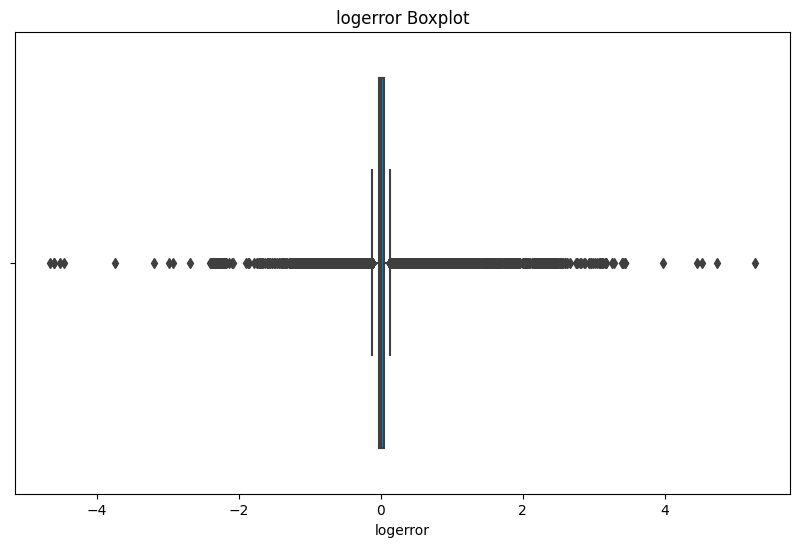

logerror 1% 분위수: -0.3311, 99% 분위수: 0.4959
열 'bathroomcnt' 결측치 42개 → 중앙값 2.0으로 대체
열 'bedroomcnt' 결측치 42개 → 중앙값 3.0으로 대체
열 'calculatedbathnbr' 결측치 95개 → 중앙값 2.0으로 대체
열 'calculatedfinishedsquarefeet' 결측치 49개 → 중앙값 1543.0으로 대체
열 'finishedsquarefeet12' 결측치 685개 → 중앙값 1524.0으로 대체
열 'finishedsquarefeet13' 결측치 164035개 → 중앙값 1344.0으로 대체
열 'finishedsquarefeet15' 결측치 147640개 → 0으로 대체 (부동산 도메인 지식 적용)
열 'finishedsquarefeet50' 결측치 141166개 → 중앙값 1263.0으로 대체
열 'finishedsquarefeet6' 결측치 162713개 → 0으로 대체 (부동산 도메인 지식 적용)
열 'garagetotalsqft' 결측치 76718개 → 0으로 대체 (부동산 도메인 지식 적용)
열 'latitude' 결측치 42개 → 중앙값 34021386.0으로 대체
열 'longitude' 결측치 42개 → 중앙값 -118175082.0으로 대체
열 'lotsizesquarefeet' 결측치 1624개 → 0으로 대체 (부동산 도메인 지식 적용)
열 'rawcensustractandblock' 결측치 42개 → 중앙값 60376200.011008으로 대체
열 'regionidcity' 결측치 123개 → 중앙값 25218.0으로 대체
열 'regionidneighborhood' 결측치 58751개 → 중앙값 118849.0으로 대체
열 'regionidzip' 결측치 42개 → 중앙값 96393.0으로 대체
열 'unitcnt' 결측치 16552개 → 0으로 대체 (부동산 도메인 지식 적용)
열 'yearbuilt' 결측치 53개 → 중앙값 1970.0으로

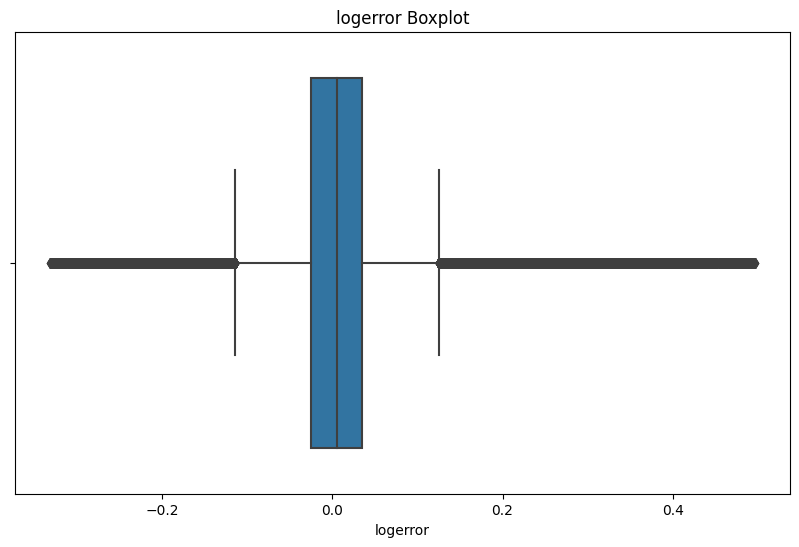

In [24]:
# 12. 이상치 처리 (고정 범위 및 1%~99% 분위수, IQR 배수 7.0 적용, 부동산 데이터 특성 고려)
print("이상치 처리 시작...")

# ① logerror 분포 분석 및 박스플롯 출력
print("logerror 분포 분석...")
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df_encoded['logerror'])
plt.title("logerror Boxplot")
plt.show()

# ② logerror 극단값 제거: 1%~99% 분위수 기준으로 제한
logerror_lower, logerror_upper = train_df_encoded['logerror'].quantile([0.01, 0.99])
print(f"logerror 1% 분위수: {logerror_lower:.4f}, 99% 분위수: {logerror_upper:.4f}")
train_df_cleaned = train_df_encoded[
    train_df_encoded['logerror'].between(logerror_lower, logerror_upper, inclusive='both')
]

# ③ 숫자형 피처 이상치 제거
numeric_cols = train_df_encoded.select_dtypes(include=['int32', 'float64']).columns.drop('logerror', errors='ignore')

# 우선 결측치 처리: 도메인 지식에 따라 특정 피처는 0으로, 나머지는 중앙값으로 채움
for col in numeric_cols:
    if train_df_cleaned[col].isnull().sum() > 0:
        if col in ['finishedsquarefeet15', 'finishedsquarefeet6', 'lotsizesquarefeet', 'garagetotalsqft', 'unitcnt']:
            print(f"열 '{col}' 결측치 {train_df_cleaned[col].isnull().sum()}개 → 0으로 대체 (부동산 도메인 지식 적용)")
            train_df_cleaned[col] = train_df_cleaned[col].fillna(0)
        else:
            median_val = train_df_cleaned[col].median()
            print(f"열 '{col}' 결측치 {train_df_cleaned[col].isnull().sum()}개 → 중앙값 {median_val}으로 대체")
            train_df_cleaned[col] = train_df_cleaned[col].fillna(median_val)

# ④ 각 숫자형 피처에 대해 1%~99% 분위수와 IQR 배수 7.0 기준을 함께 적용하여 이상치 제거
for col in numeric_cols:
    if train_df_cleaned[col].notnull().sum() > 0:
        # 1%~99% 분위수 기준
        q_low, q_high = train_df_cleaned[col].quantile([0.01, 0.99])
        # IQR 기준 (7.0 배수)
        Q1 = train_df_cleaned[col].quantile(0.25)
        Q3 = train_df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_iqr = Q1 - 7.0 * IQR
        upper_iqr = Q3 + 7.0 * IQR
        # 최종 경계: 두 기준 중 더 엄격한(큰 값으로 lower_bound, 작은 값으로 upper_bound)
        lower_bound = max(q_low, lower_iqr)
        upper_bound = min(q_high, upper_iqr)
        
        # 도메인 지식 적용: 부동산 피처에서 값이 0 이상인 경우는 정상으로 간주
        if col in ['finishedsquarefeet15', 'finishedsquarefeet6', 'lotsizesquarefeet', 'garagetotalsqft', 'unitcnt']:
            valid_indices = (train_df_cleaned[col].between(lower_bound, upper_bound, inclusive='both')) | (train_df_cleaned[col] >= 0)
        else:
            valid_indices = train_df_cleaned[col].between(lower_bound, upper_bound, inclusive='both')
        
        before_count = train_df_cleaned.shape[0]
        train_df_cleaned = train_df_cleaned[valid_indices]
        after_count = train_df_cleaned.shape[0]
        print(f"열 '{col}': {before_count - after_count} 행 제거 (범위: [{lower_bound:.2f}, {upper_bound:.2f}])")
    else:
        print(f"[주의] 열 '{col}'에 유효 데이터가 없습니다. 유지합니다.")

print(f"이상치 제거 후 데이터 크기: {train_df_cleaned.shape}")

# logerror 분포 
print("logerror 분포 분석...")
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df_cleaned['logerror'])
plt.title("logerror Boxplot")
plt.show()



In [25]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance


=== [13] 최종 결측치 처리 ===
[숫자형 피처 결측치 현황]
logerror                            0
bathroomcnt                         0
bedroomcnt                          0
calculatedbathnbr                   0
calculatedfinishedsquarefeet        0
finishedsquarefeet12                0
finishedsquarefeet13                0
finishedsquarefeet15                0
finishedsquarefeet50                0
finishedsquarefeet6                 0
garagetotalsqft                     0
latitude                            0
longitude                           0
lotsizesquarefeet                   0
rawcensustractandblock              0
regionidcity                        0
regionidneighborhood                0
regionidzip                         0
unitcnt                             0
yearbuilt                           0
structuretaxvaluedollarcnt          0
taxvaluedollarcnt                   0
landtaxvaluedollarcnt               0
taxamount                           0
censustractandblock                 0
transactio

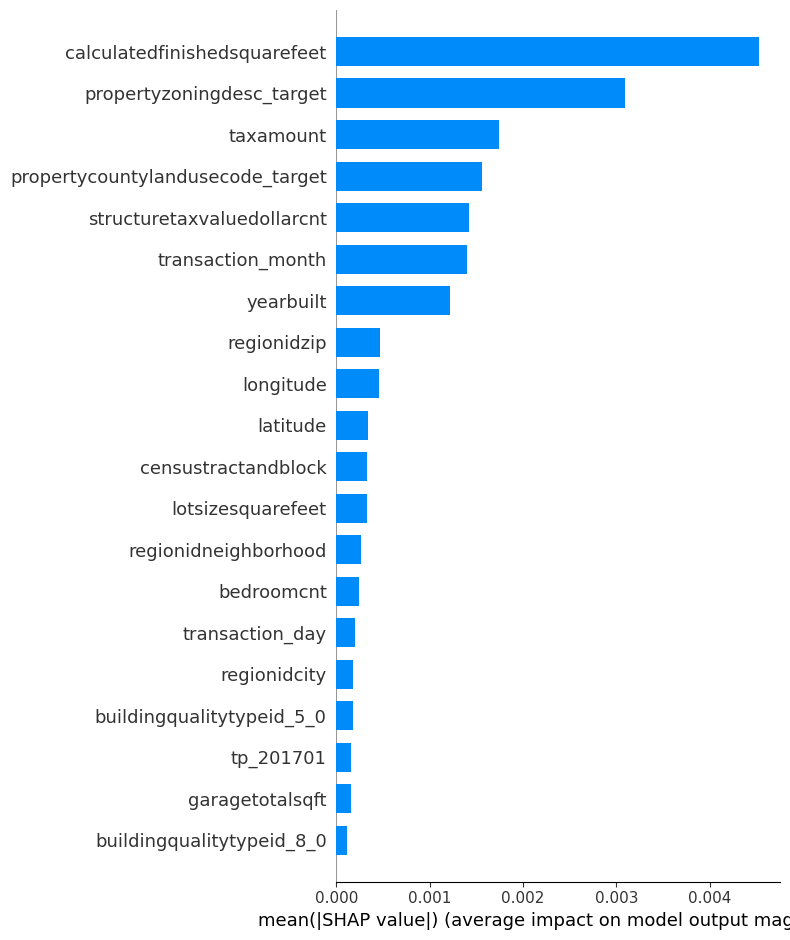

In [27]:
# 13. 결측치 처리 (최종)
print("\n=== [13] 최종 결측치 처리 ===")
num_cols = train_df_cleaned.select_dtypes(include=['int32', 'float64']).columns
bool_cols = train_df_cleaned.select_dtypes(include=['bool']).columns

# 이미 이상치 처리 과정에서 결측치는 채워졌으므로, 여기서는 추가 확인만
print("[숫자형 피처 결측치 현황]")
print(train_df_cleaned[num_cols].isnull().sum())

# 90% 이상 결측치는 제거 (도메인 지식 반영)
miss_ratio = train_df_cleaned[num_cols].isnull().mean()
cols_to_drop = miss_ratio[miss_ratio > 0.9].index
if len(cols_to_drop) > 0:
    print(f"[주의] 결측치 비율 90% 이상 칼럼 제거: {list(cols_to_drop)}")
    train_df_cleaned = train_df_cleaned.drop(columns=cols_to_drop)

# 나머지는 다시 중앙값 또는 0으로 대체
for col in num_cols:
    if train_df_cleaned[col].isnull().sum() > 0:
        if col in ['finishedsquarefeet15', 'finishedsquarefeet6', 'lotsizesquarefeet', 'garagetotalsqft', 'unitcnt']:
            train_df_cleaned[col] = train_df_cleaned[col].fillna(0)
        else:
            train_df_cleaned[col] = train_df_cleaned[col].fillna(train_df_cleaned[col].median())

for col in bool_cols:
    if train_df_cleaned[col].isnull().sum() > 0:
        train_df_cleaned[col] = train_df_cleaned[col].fillna(train_df_cleaned[col].mode()[0])

print("\n[결측치 처리 후]")
print(train_df_cleaned.isnull().sum().sum())

# 14. 중복 피처 제거 및 피처 선택 강화 (상관계수 0.9 이상, 도메인 지식 기반, 빈도 수 필터링)
print("\n=== [14] 중복/고상관 피처 제거 및 피처 선택 단계 ===")
all_cols_final = train_df_cleaned.select_dtypes(include=['int32','float64','bool']).columns
df_numeric = train_df_cleaned[all_cols_final].copy()

# 만약 결측치가 남았다면 일괄 제거
if df_numeric.isnull().sum().sum() > 0:
    print("[주의] df_numeric에 결측치 존재 → dropna() 수행")
    print(df_numeric.isnull().sum())
    df_numeric = df_numeric.dropna()

if len(df_numeric) < 100 or 'logerror' not in df_numeric.columns:
    print("🚨 [오류] 샘플 수가 부족하거나 'logerror' 열이 없습니다. (최소 100개 필요)")
    final_df = pd.DataFrame(columns=['logerror'])
else:
    numeric_only = df_numeric.select_dtypes(include=['int32','float64']).columns
    corr_matrix = df_numeric[numeric_only].corr()
    high_corr_pairs = []
    for c1 in corr_matrix.columns:
        for c2 in corr_matrix.columns:
            if c1 < c2 and abs(corr_matrix.loc[c1, c2]) > 0.9:
                high_corr_pairs.append((c1, c2))
    
    # 피처 중요도 (랜덤포레스트) 계산
    X_temp = df_numeric.drop('logerror', axis=1, errors='ignore')
    y_temp = df_numeric['logerror']
    rf_temp = ExtraTreesRegressor(n_estimators=50, random_state=42, n_jobs=4)
    rf_temp.fit(X_temp, y_temp)
    result = permutation_importance(rf_temp, X_temp, y_temp, n_repeats=5, random_state=42, scoring='neg_mean_absolute_error')
    
    imp_df = pd.DataFrame({
        'feature': X_temp.columns,
        'importance': result.importances_mean
    }).sort_values('importance', ascending=False)
    imp_dict = dict(zip(imp_df['feature'], imp_df['importance']))
    
    final_features = list(df_numeric.columns)
    if 'logerror' in final_features:
        final_features.remove('logerror')
    
    for (col1, col2) in high_corr_pairs:
        if col1 in final_features and col2 in final_features:
            imp1 = imp_dict.get(col1, 0)
            imp2 = imp_dict.get(col2, 0)
            if imp1 >= imp2:
                final_features.remove(col2)
            else:
                final_features.remove(col1)
    final_features.append('logerror')
    final_df = df_numeric[final_features].copy()
    
    print("[최종 유지된 피처]")
    print(final_features)

# 15. 피처 스케일링
print("\n=== [15] 피처 스케일링 단계 ===")
scaler = StandardScaler(with_mean=False)  # bool 데이터는 0/1 그대로 유지
if 'logerror' in final_df.columns:
    X = final_df.drop('logerror', axis=1)
    y = final_df['logerror']
    
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
else:
    X_scaled_df = pd.DataFrame()
    y = pd.Series()

# 16. 시점별(timepoint) 피처 생성
print("\n=== [16] 시점별 피처 생성 ===")
if 'transaction_year' in train_df_cleaned.columns and 'transaction_month' in train_df_cleaned.columns:
    train_df_cleaned['timepoint'] = (
        train_df_cleaned['transaction_year'].astype(str) 
        + train_df_cleaned['transaction_month'].astype(str).str.zfill(2)
    )
    tp_dummies = pd.get_dummies(train_df_cleaned['timepoint'], prefix='tp')
    
    # train_df_final에도 추가 (여기서는 X_scaled_df에 적용)
    if not X_scaled_df.empty:
        X_scaled_df = pd.concat([X_scaled_df, tp_dummies.loc[X_scaled_df.index]], axis=1)
        # 중복 이름 처리
        def make_unique(columns):
            seen = {}
            unique_cols = []
            for col in columns:
                if col in seen:
                    seen[col] += 1
                    unique_cols.append(f"{col}_{seen[col]}")
                else:
                    seen[col] = 0
                    unique_cols.append(col)
            return unique_cols
        X_scaled_df.columns = X_scaled_df.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
        X_scaled_df.columns = make_unique(X_scaled_df.columns)
    else:
        print("[주의] X_scaled_df가 비어있어 시점별 피처 추가 불가.")
else:
    print("[주의] 'transaction_year' 또는 'transaction_month'가 없습니다. 시점별 피처 생성 불가.")

# 17. 모델링 (하이퍼파라미터 튜닝 및 앙상블)
print("\n=== [17] 모델링 단계 ===")
if not X_scaled_df.empty and len(y) > 0 and X_scaled_df.shape[0] >= 100:
    if y.ndim > 1:
        y = y.ravel()
    
    # 데이터 샘플링: 전체 데이터의 50%만 사용해 튜닝 (추후 전체 데이터로 재학습)
    sample_ratio = 0.5
    sample_size = int(len(X_scaled_df) * sample_ratio)
    X_sample, _, y_sample, _ = train_test_split(X_scaled_df, y, test_size=(1 - sample_ratio), random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_sample, y_sample, test_size=0.2, random_state=42
    )
    
    # 교차검증 폴드 수 줄이기: 3-fold 사용
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # 파라미터 범위 약간 축소
    param_space_rf = {
        'n_estimators': (100, 200),
        'max_depth': (5, 15),
        'min_samples_split': (2, 5),
        'min_samples_leaf': (1, 3)
    }
    param_space_xgb = {
        'n_estimators': (100, 200),
        'max_depth': (5, 15),
        'learning_rate': (0.01, 0.1, 'log-uniform'),
        'reg_alpha': (0.01, 0.1, 'log-uniform')
    }
    param_space_lgb = {
        'n_estimators': (100, 200),
        'max_depth': (5, 15),
        'learning_rate': (0.01, 0.1, 'log-uniform'),
        'reg_alpha': (0.01, 0.1, 'log-uniform'),
        'min_data_in_leaf': (1, 5),
        'min_data_in_bin': (1, 5)
    }
    
    # n_iter 축소: 10으로 설정
    opt_rf = BayesSearchCV(
        RandomForestRegressor(random_state=42),
        param_space_rf, n_iter=10, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1
    )
    opt_xgb = BayesSearchCV(
    xgb.XGBRegressor(tree_method='gpu_hist', random_state=42),  
    param_space_xgb, n_iter=10, cv=kf, scoring='neg_mean_absolute_error') # ✅ XGBoost GPU 사용
    
    opt_lgb = BayesSearchCV(
    lgb.LGBMRegressor(device='gpu', random_state=42), 
    param_space_lgb, n_iter=10, cv=kf, scoring='neg_mean_absolute_error') # ✅ LightGBM GPU 사용

    
    print("\n🚀 모델 학습 시작 (샘플 데이터 사용)...")
    opt_rf.fit(X_train, y_train)
    opt_xgb.fit(X_train, y_train)
    opt_lgb.fit(X_train, y_train)
    
    rf_model = opt_rf.best_estimator_
    xgb_model = opt_xgb.best_estimator_
    lgb_model = opt_lgb.best_estimator_
    
    rf_pred = rf_model.predict(X_val)
    xgb_pred = xgb_model.predict(X_val)
    lgb_pred = lgb_model.predict(X_val)

    # 교차 검증 점수
    rf_scores = cross_val_score(rf_model, X_scaled_df, y, cv=kf, scoring='neg_mean_absolute_error')
    xgb_scores = cross_val_score(xgb_model, X_scaled_df, y, cv=kf, scoring='neg_mean_absolute_error')
    lgb_scores = cross_val_score(lgb_model, X_scaled_df, y, cv=kf, scoring='neg_mean_absolute_error')

    # CV MAE와 검증 MAE 출력하여 과적합 여부 확인
    print("랜덤포레스트 CV MAE (최적화 후):", -rf_scores.mean())
    print("XGBoost CV MAE (최적화 후):", -xgb_scores.mean())
    print("LightGBM CV MAE (최적화 후):", -lgb_scores.mean())
    print("랜덤포레스트 검증 MAE:", mean_absolute_error(y_val, rf_pred))
    print("XGBoost 검증 MAE:", mean_absolute_error(y_val, xgb_pred))
    print("LightGBM 검증 MAE:", mean_absolute_error(y_val, lgb_pred))

    # 모델 앙상블 (가중 평균, CV MAE 기준으로 조정)
    rf_weight = 1 / (-rf_scores.mean())
    xgb_weight = 1 / (-xgb_scores.mean())
    lgb_weight = 1 / (-lgb_scores.mean())
    total_weight = rf_weight + xgb_weight + lgb_weight
    ensemble_pred = (rf_pred * rf_weight + xgb_pred * xgb_weight + lgb_pred * lgb_weight) / total_weight
    print("앙상블 MAE:", mean_absolute_error(y_val, ensemble_pred))

# 18. 피처 중요도 시각화 (SHAP로 해석력 강화)
explainer = shap.TreeExplainer(xgb_model)  # ✅ XGBoost 기반으로 SHAP 분석 수행
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values,X_val,plot_type ='bar')